## **ConvNets for bimatrix gameplay trained with KL Divergence**

*Note: Following was run on Google Colab.*

In [0]:
%matplotlib inline

import pandas as pd
import numpy as np
from tqdm import tqdm

import torch
import torch.optim as optim
from torch.utils.data import Dataset

import matplotlib.pyplot as plt

In [12]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

In [0]:
df_train_features = pd.read_csv('./hb_train_feature.csv')
df_test_features = pd.read_csv('./hb_test_feature.csv')
df_train_truth = pd.read_csv('./hb_train_truth.csv')

## **Configuration Variables**

In [0]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
BATCH_SIZE = 32
SHUFFLE = True
SEED = 42
TRAIN_SPLIT = 0.6
VAL_SPLIT = 0.2
TEST_SPLIT = 0.2
EPOCHS = 10

## **Configure Data**

In [0]:
def view_game_matrix(df_row):
    """
    View payoffs in 3x3 matrix format
    inputs
        df_row : Pandas series object, e.g. df.iloc[0]
    returns
        [row_payoffs, col_payoffs] : np.array (2x3x3)
    """
    return df_row.values.reshape(2, 3, 3)

def normalize(matrix):
    """
    Method to normalize a given matrix
    input:
        matrix : np.array, the payouts 
    output:
        np.array, the matrix normalized
    """
    min_val = np.min(matrix)
    max_val = np.max(matrix)
    return (matrix - min_val) / (max_val - min_val)
    
def get_payoff_matrices(df, rows_first=False, normalized=True):
    """
    Convert input dataframe into new normed payoff data
    input:
        df : pandas.DataFrame
        rows_first : bool, if true, separate data into first row payoffs and then columns, 
        otherwise row and col payoffs lumped next to each other
        normalized : bool, if true, normalize the matrices
    output:
        np.array, the converted data 
    """
    if normalized:
        df = df.apply(normalize, axis=0)
    matrices = np.zeros([2 * df.shape[0], 3, 3])
    for row_ix in range(df.shape[0]):
        payoffs = view_game_matrix(df.iloc[row_ix])
        if rows_first:
            matrices[row_ix] = payoffs[0]
            matrices[row_ix + df.shape[0]] = payoffs[1]
        else:
            matrices[row_ix * 2] = payoffs[0]
            matrices[row_ix * 2 + 1] = payoffs[1]
#     if normalized:
#         matrices = np.array([normalize(matrices[ix]) for ix in range(matrices.shape[0])])
    return matrices

In [0]:
def transform(payoffs, rotations):  # rotations = [2, 1, 0]
#     temp = norm_payoffs_c[:, 0]
    new_payoffs = np.zeros(payoffs.shape)
    for ix in range(len(rotations)):
        new_payoffs[:, ix] = payoffs[:, rotations[ix]]
    return new_payoffs

In [0]:
import itertools
orderings = list(itertools.permutations([0, 1, 2]))

### **Generate payoff matrices and augmentations**

In [0]:
# Get payoff matrices and augment
norm_payoffs = get_payoff_matrices(df_train_features, rows_first=True, normalized=True)
norm_payoffs_r = norm_payoffs[:250]
norm_payoffs_c = norm_payoffs[250:]

augmented_data = []
augmented_labels = []
for order in orderings:
    trans_payoffs_r = transform(norm_payoffs_r, order)
    trans_payoffs_c = transform(norm_payoffs_c, order)
    trans_freq = df_train_truth.apply(lambda x: x[list(order)], axis=1).values
    augmented_data.append(np.array([trans_payoffs_r, trans_payoffs_c]))
    augmented_labels.append(trans_freq)

In [0]:
game_data = np.array(augmented_data).transpose([0, 2, 1, 3, 4]).reshape(250 * 6, 2, 3, 3)
game_labels = np.array(augmented_labels).reshape(250 * 6, 3)

### **Generate alternative input features**

In [0]:
# Difference between the row and col payoffs
game_data_rc_diffs = game_data[:, 0, :, :] - game_data[:, 1, :, :]

# Difference between the payoff max and payoffs

## Get maxes
max_rows = np.max(game_data[:, 0, :, :], axis=(1, 2))
max_cols = np.max(game_data[:, 1, :, :], axis=(1, 2))

## Expand and convert to previous data shape
max_rows = np.repeat(max_rows, 9).reshape((1500, 3, 3))
max_cols = np.repeat(max_cols, 9).reshape((1500, 3, 3))

game_data_maxdiff_r = game_data[:, 0, :, :] - max_rows
game_data_maxdiff_c = game_data[:, 1, :, :] - max_cols

In [0]:
game_data_diffs = np.array([game_data_rc_diffs, game_data_maxdiff_r, game_data_maxdiff_c]).transpose(1, 0, 2, 3)
game_data_combined = np.concatenate([game_data, game_data_diffs], axis=1)
game_data_row = np.concatenate([np.expand_dims(game_data[:, 0, :, :], 1), game_data_diffs[:,0:2, :, :]], axis=1)

### **Define PyTorch Game Dataset**

In [0]:
class GameDataset(Dataset):
    """Bimatrix game dataset"""
    def __init__(self, data, labels):
        """
        Args:
            data: game payoffs; (num_samples, channels, row, col)
            labels: frequency of actions; (num_samples, freq)
        """
        self.samples = []
        self.data = data
        self.labels = labels
        self.load_samples()
        
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, ix):
        return self.samples[ix]

    def load_samples(self):
        for ix in range(self.data.shape[0]):
            self.samples.append((
                torch.tensor(self.data[ix], dtype=torch.float).to(DEVICE), 
                torch.tensor(self.labels[ix], dtype=torch.float).to(DEVICE)))
            
def load_game_data(data, labels, batch_size=BATCH_SIZE, shuffle=SHUFFLE):
    torch.manual_seed(SEED)
    dataset = GameDataset(data, labels)
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size = batch_size, shuffle=shuffle)
    return dataloader

## **Setup Training**

#### **Default Training Sets**

In [0]:
np.random.seed(SEED)

# Shuffle data first
game_ix = list(range(len(game_data)))
np.random.shuffle(game_ix)

game_data_ = game_data[game_ix]
game_labels_ = game_labels[game_ix]

# Prepare splits
train_split = int(len(game_data_) * TRAIN_SPLIT)
test_split = int(len(game_data_) * (TRAIN_SPLIT + VAL_SPLIT))

train_data = game_data_[:train_split]
val_data = game_data_[train_split:test_split]
test_data = game_data_[test_split:]

train_labels = game_labels_[:train_split]
val_labels = game_labels_[train_split:test_split]
test_labels = game_labels_[test_split:]

train_val_data = game_data_[:test_split]
train_val_labels = game_labels_[:test_split]

### **Differences Training Sets**

In [0]:
np.random.seed(SEED)

# Shuffle data first
game_ix = list(range(len(game_data_diffs)))
np.random.shuffle(game_ix)

game_data_diffs_ = game_data_diffs[game_ix]
game_labels_ = game_labels[game_ix]

# Prepare splits
train_split = int(len(game_data_diffs_) * TRAIN_SPLIT)
test_split = int(len(game_data_diffs_) * (TRAIN_SPLIT + VAL_SPLIT))

train_data_diffs = game_data_diffs_[:train_split]
val_data_diffs = game_data_diffs_[train_split:test_split]
test_data_diffs = game_data_diffs_[test_split:]

train_labels = game_labels_[:train_split]
val_labels = game_labels_[train_split:test_split]
test_labels = game_labels_[test_split:]

train_val_data_diffs = game_data_diffs_[:test_split]
train_val_labels = game_labels_[:test_split]

### **All Features Training Sets**

In [0]:
np.random.seed(SEED)

# Shuffle data first
game_ix = list(range(len(game_data_combined)))
np.random.shuffle(game_ix)

game_data_combined_ = game_data_combined[game_ix]
game_labels_ = game_labels[game_ix]

# Prepare splits
train_split = int(len(game_data_combined_) * TRAIN_SPLIT)
test_split = int(len(game_data_combined_) * (TRAIN_SPLIT + VAL_SPLIT))

train_data_combined = game_data_combined_[:train_split]
val_data_combined = game_data_combined_[train_split:test_split]
test_data_combined = game_data_combined_[test_split:]

train_labels = game_labels_[:train_split]
val_labels = game_labels_[train_split:test_split]
test_labels = game_labels_[test_split:]

train_val_data_combined = game_data_combined_[:test_split]
train_val_labels = game_labels_[:test_split]

### **Row Player Training Sets**

In [0]:
np.random.seed(SEED)

# Shuffle data first
game_ix = list(range(len(game_data_row)))
np.random.shuffle(game_ix)

game_data_row_ = game_data_row[game_ix]
game_labels_ = game_labels[game_ix]

# Prepare splits
train_split = int(len(game_data_row_) * TRAIN_SPLIT)
test_split = int(len(game_data_row_) * (TRAIN_SPLIT + VAL_SPLIT))

train_data_row = game_data_row_[:train_split]
val_data_row = game_data_row_[train_split:test_split]
test_data_row = game_data_row_[test_split:]

train_labels = game_labels_[:train_split]
val_labels = game_labels_[train_split:test_split]
test_labels = game_labels_[test_split:]

train_val_data_row = game_data_row_[:test_split]
train_val_labels = game_labels_[:test_split]

### **Training Methods**

In [0]:
def batch_quadratic_loss(batch_output, batch_label):
    loss = 0
    for ix in range(len(batch_output)):
        loss += np.sum([(batch_output[ix][i] - batch_label[ix][i]) ** 2. for i in range(3)])
    return loss
        

def evaluate(model, dataloader, model_softmax=False):
    softmax = nn.Softmax(dim=1)
    batch_quad_loss = 0
    outputs = []
    labels = []
    model.eval()
    for batch_ix, (data, label) in enumerate(dataloader):
        if model.soft:
            output = model(data)
        elif model.log:
            output = torch.exp(model(data))  # convert back regular probabilities
        else:
            output = softmax(model(data))
        batch_quad_loss += batch_quadratic_loss(output, label).cpu().detach().numpy()
        outputs.append(output.squeeze().cpu().detach().numpy())
        labels.append(label.squeeze().cpu().detach().numpy())

    val_actions = np.argmax(np.array(labels), axis=1)
    pred_actions = np.argmax(np.array(outputs), axis=1)
    action_acc = np.sum(val_actions == pred_actions) / val_actions.shape[0]

    return batch_quad_loss, action_acc, outputs

def train(model, loss_fn, dataloader, dataloader_val=None, epochs=EPOCHS, 
          log_targets=False, model_softmax=True, log=5, log_softmax_outputs=False, val_data=val_data, val_labels=val_labels):

    # # Multiple criterion
    # mse_loss = nn.MSELoss()
    # ce_loss = nn.CrossEntropyLoss() 
    softmax_fn = nn.Softmax(dim=1)
    log_softmax_fn = nn.LogSoftmax(dim=1)

    dataloader_actual_val = load_game_data(val_data, val_labels, batch_size=1, shuffle=False)
    loss_total = []
    acc_total = []
    acc_total_val = []
    for epoch in range(epochs):  # tqdm is buggy sometimes
        epoch_loss = 0
        for batch_ix, (data, label) in enumerate(dataloader):
            # print(data.shape)
            output = model(data)
            # print(output)
            target = torch.tensor(np.argmax(np.array(label.cpu()), axis=1), dtype=torch.long).to(DEVICE)
            optimizer.zero_grad()
            # loss = 1.0 * mse_loss(softmax(output), label) + 0.0 * ce_loss(output, target)
            if log_targets:
                # output = log_softmax_fn(output)
                label = torch.log(label)
                # print(label)
            if log_softmax_outputs:
                output = log_softmax_fn(output)
                # print(output)
            elif not model_softmax:
                output = softmax_fn(output)
            loss = loss_fn(output, label)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        loss_total.append(epoch_loss)
        quad_loss, acc, _ = evaluate(model, dataloader_val, model_softmax=model_softmax)
        quad_loss_val, acc_val, _ = evaluate(model, dataloader_actual_val, model_softmax=model_softmax)
        if (epoch + 1) % log == 0:
            print('Epoch {0:<2} | Training Loss: {1:<2f} | Quad Loss: {2:<2f} | Acc: {3:<2f} | Val Quad Loss: {4:<2f} | Val Acc: {5:<2f}'.format(
                epoch, epoch_loss, quad_loss, acc, quad_loss_val, acc_val))
        acc_total.append(acc)
        acc_total_val.append(acc_val)
    return loss_total, [acc_total, acc_total_val]

## **Define ConvNet**

In [0]:
import torch.nn as nn  
import torch.nn.functional as F

In [0]:
class ConvNetPdBig(nn.Module):
    """
    ConvNet Model for all features data. Variable number of channels
    """
    def __init__(self, log_softmax=False, softmax=True, dropout=0., channels=3):
        super(ConvNetPdBig, self).__init__()
        self.log = log_softmax
        self.soft = softmax
        # Input: 3 channels, 8 output channels, 3x3 conv -> 8x3x3 output
        self.conv1 = nn.Conv2d(channels, 32, 3, padding=1) 
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)  
        self.fc1 = nn.Linear(128 * 3 * 3, 512)  
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 32)
        self.fc4 = nn.Linear(32, 3)  # Predict all three frequencies, use Softmax?
        self.log_softmax = nn.LogSoftmax(dim=1)
        self.softmax = nn.Softmax(dim=1)
        self.dropout_conv = nn.Dropout2d(p=0.1)
        self.dropout_fcn = nn.Dropout(p=dropout)
        self.gradients = None  # Placeholder for gradients

    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.dropout_conv(x)
        x = F.relu(self.conv2(x))
        x = self.dropout_conv(x)
        x = F.relu(self.conv3(x))
        # Hook to capture the gradients
        h = x.register_hook(self.activations_hook)
        x = self.dropout_conv(x)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = self.dropout_fcn(x)
        x = F.relu(self.fc2(x))
        x = self.dropout_fcn(x)
        x = F.relu(self.fc3(x))
        x = self.dropout_fcn(x)
        x = self.fc4(x)
        if self.log:
            return self.log_softmax(x)
        elif self.soft:
            return self.softmax(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # All dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

    # Method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # Method for the activation extraction
    def get_activations(self, x):
        activations = []
        x = F.relu(self.conv1(x))
        activations.append(x)
        x = self.dropout_conv(x)
        x = F.relu(self.conv2(x))
        activations.append(x)
        x = self.dropout_conv(x)
        x = F.relu(self.conv3(x))
        activations.append(x)
        return activations

## **Training Setup 1: Differences**

Epoch 4  | Training Loss: 115.306964 | Quad Loss: 61.063488 | Acc: 0.776667 | Val Quad Loss: 20.466595 | Val Acc: 0.690000
Epoch 9  | Training Loss: 103.776782 | Quad Loss: 55.047623 | Acc: 0.795833 | Val Quad Loss: 20.619893 | Val Acc: 0.696667
Epoch 14 | Training Loss: 96.769837 | Quad Loss: 54.719154 | Acc: 0.796667 | Val Quad Loss: 20.774978 | Val Acc: 0.703333
Epoch 19 | Training Loss: 89.352555 | Quad Loss: 49.213323 | Acc: 0.812500 | Val Quad Loss: 20.692470 | Val Acc: 0.716667
Epoch 24 | Training Loss: 80.979633 | Quad Loss: 39.456759 | Acc: 0.843333 | Val Quad Loss: 19.062653 | Val Acc: 0.750000
Epoch 29 | Training Loss: 71.887032 | Quad Loss: 34.956803 | Acc: 0.856667 | Val Quad Loss: 18.214008 | Val Acc: 0.743333
Epoch 34 | Training Loss: 65.552649 | Quad Loss: 28.859971 | Acc: 0.873333 | Val Quad Loss: 17.918734 | Val Acc: 0.750000
Epoch 39 | Training Loss: 55.142360 | Quad Loss: 28.866429 | Acc: 0.863333 | Val Quad Loss: 20.027733 | Val Acc: 0.736667
Epoch 44 | Training Lo

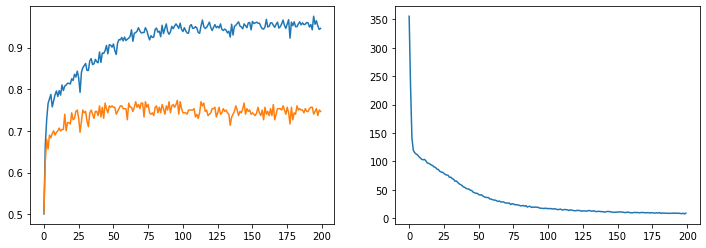

19.223789348128776 0.7466666666666667


In [27]:
# Actually train
model_pd = ConvNetPdBig(log_softmax=True, softmax=False)
model_pd = model_pd.to(DEVICE)

criterion = nn.KLDivLoss(reduction='sum')
optimizer = optim.Adam(model_pd.parameters(), lr=1e-4, weight_decay=0.0001)

dataloader = load_game_data(train_val_data_diffs, train_val_labels, batch_size=4, shuffle=True)
EPOCHS = 50

dataloader_val = load_game_data(train_val_data_diffs, train_val_labels, batch_size=1, shuffle=False)
losses_4, acc_4 = train(model_pd, criterion, dataloader, dataloader_val, epochs=200, 
                        log_targets=False, model_softmax=True, log=5, val_data=test_data_diffs, val_labels=test_labels)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc_4[0])
plt.plot(acc_4[1])
plt.subplot(1, 2, 2)
plt.plot(losses_4)
plt.show()

dataloader_val = load_game_data(test_data_diffs, test_labels, batch_size=1, shuffle=False)
batch_ql, acc, predictions = evaluate(model_pd, dataloader_val)
print(batch_ql, acc)

Epoch 19 | Training Loss: 86.879631 | Quad Loss: 46.833438 | Acc: 0.818333 | Val Quad Loss: 20.595717 | Val Acc: 0.726667
Epoch 39 | Training Loss: 59.618096 | Quad Loss: 29.292959 | Acc: 0.868333 | Val Quad Loss: 19.271916 | Val Acc: 0.720000
Epoch 59 | Training Loss: 38.781122 | Quad Loss: 18.483876 | Acc: 0.905833 | Val Quad Loss: 20.358868 | Val Acc: 0.753333
Epoch 79 | Training Loss: 26.080088 | Quad Loss: 9.628044 | Acc: 0.934167 | Val Quad Loss: 19.569555 | Val Acc: 0.743333
Epoch 99 | Training Loss: 19.147824 | Quad Loss: 6.392006 | Acc: 0.945000 | Val Quad Loss: 21.782824 | Val Acc: 0.763333
Epoch 119 | Training Loss: 14.147441 | Quad Loss: 5.348870 | Acc: 0.950000 | Val Quad Loss: 21.406817 | Val Acc: 0.743333
Epoch 139 | Training Loss: 12.148454 | Quad Loss: 5.173464 | Acc: 0.948333 | Val Quad Loss: 20.566089 | Val Acc: 0.776667
Epoch 159 | Training Loss: 10.859526 | Quad Loss: 7.170029 | Acc: 0.949167 | Val Quad Loss: 20.578759 | Val Acc: 0.763333
Epoch 179 | Training Loss:

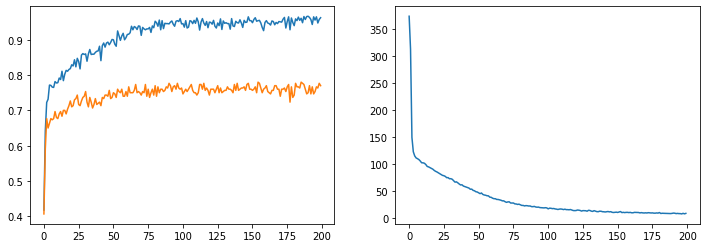

19.794063421839382 0.77


In [30]:
# Actually train
model_pd = ConvNetPdBig(log_softmax=True, softmax=False)
model_pd = model_pd.to(DEVICE)

criterion = nn.KLDivLoss(reduction='sum')
optimizer = optim.Adam(model_pd.parameters(), lr=1e-4, weight_decay=0.0001)

dataloader = load_game_data(train_val_data_diffs, train_val_labels, batch_size=4, shuffle=True)
EPOCHS = 50

dataloader_val = load_game_data(train_val_data_diffs, train_val_labels, batch_size=1, shuffle=False)
losses_4, acc_4 = train(model_pd, criterion, dataloader, dataloader_val, epochs=200, 
                        log_targets=False, model_softmax=True, log=20, val_data=test_data_diffs, val_labels=test_labels)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc_4[0])
plt.plot(acc_4[1])
plt.subplot(1, 2, 2)
plt.plot(losses_4)
plt.show()

dataloader_val = load_game_data(test_data_diffs, test_labels, batch_size=1, shuffle=False)
batch_ql, acc, predictions = evaluate(model_pd, dataloader_val)
print(batch_ql, acc)

ERROR! Session/line number was not unique in database. History logging moved to new session 59
Epoch 19 | Training Loss: 4.523739 | Quad Loss: 52.133401 | Acc: 0.802500 | Val Quad Loss: 21.235226 | Val Acc: 0.706667
Epoch 39 | Training Loss: 3.468340 | Quad Loss: 42.482431 | Acc: 0.823333 | Val Quad Loss: 19.499259 | Val Acc: 0.693333
Epoch 59 | Training Loss: 2.616639 | Quad Loss: 30.143030 | Acc: 0.865000 | Val Quad Loss: 19.381767 | Val Acc: 0.730000
Epoch 79 | Training Loss: 1.913109 | Quad Loss: 21.408514 | Acc: 0.905833 | Val Quad Loss: 18.573422 | Val Acc: 0.750000
Epoch 99 | Training Loss: 1.472015 | Quad Loss: 14.781730 | Acc: 0.929167 | Val Quad Loss: 18.790545 | Val Acc: 0.733333
Epoch 119 | Training Loss: 1.135223 | Quad Loss: 12.553566 | Acc: 0.931667 | Val Quad Loss: 19.276622 | Val Acc: 0.763333
Epoch 139 | Training Loss: 0.953566 | Quad Loss: 9.185096 | Acc: 0.950000 | Val Quad Loss: 18.190595 | Val Acc: 0.743333
Epoch 159 | Training Loss: 0.867156 | Quad Loss: 9.036208

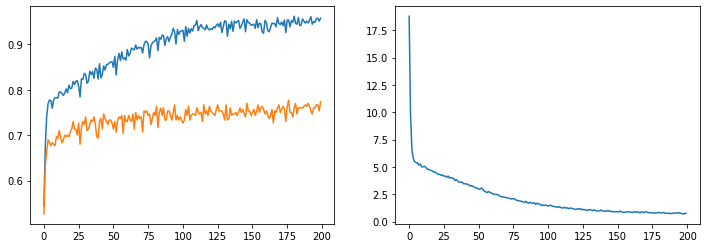

18.091642988772946 0.7733333333333333


In [33]:
# Actually train
model_pd_mse = ConvNetPdBig(log_softmax=False, softmax=True)
model_pd_mse = model_pd_mse.to(DEVICE)

criterion = nn.MSELoss()
optimizer = optim.Adam(model_pd_mse.parameters(), lr=1e-4, weight_decay=0.0001)

dataloader = load_game_data(train_val_data_diffs, train_val_labels, batch_size=4, shuffle=True)
EPOCHS = 50

dataloader_val = load_game_data(train_val_data_diffs, train_val_labels, batch_size=1, shuffle=False)
losses_4, acc_4 = train(model_pd_mse, criterion, dataloader, dataloader_val, epochs=200, 
                        log_targets=False, model_softmax=True, log=20, val_data=test_data_diffs, val_labels=test_labels)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc_4[0])
plt.plot(acc_4[1])
plt.subplot(1, 2, 2)
plt.plot(losses_4)
plt.show()

dataloader_val = load_game_data(test_data_diffs, test_labels, batch_size=1, shuffle=False)
batch_ql, acc, predictions = evaluate(model_pd_mse, dataloader_val)
print(batch_ql, acc)

## **Training Setup 2: Row Payoffs**

Epoch 19 | Training Loss: 89.408984 | Quad Loss: 48.073319 | Acc: 0.809167 | Val Quad Loss: 20.184889 | Val Acc: 0.730000
Epoch 39 | Training Loss: 60.006282 | Quad Loss: 29.596520 | Acc: 0.863333 | Val Quad Loss: 19.976236 | Val Acc: 0.716667
Epoch 59 | Training Loss: 34.808589 | Quad Loss: 14.620147 | Acc: 0.919167 | Val Quad Loss: 21.383110 | Val Acc: 0.750000
Epoch 79 | Training Loss: 22.685402 | Quad Loss: 8.047792 | Acc: 0.939167 | Val Quad Loss: 20.939719 | Val Acc: 0.716667
Epoch 99 | Training Loss: 15.537621 | Quad Loss: 5.773749 | Acc: 0.950000 | Val Quad Loss: 22.444790 | Val Acc: 0.726667
Epoch 119 | Training Loss: 11.562988 | Quad Loss: 4.197771 | Acc: 0.962500 | Val Quad Loss: 21.262376 | Val Acc: 0.743333
Epoch 139 | Training Loss: 9.843708 | Quad Loss: 4.104646 | Acc: 0.965000 | Val Quad Loss: 21.075433 | Val Acc: 0.743333
Epoch 159 | Training Loss: 8.192564 | Quad Loss: 4.132924 | Acc: 0.967500 | Val Quad Loss: 20.913198 | Val Acc: 0.743333
Epoch 179 | Training Loss: 8

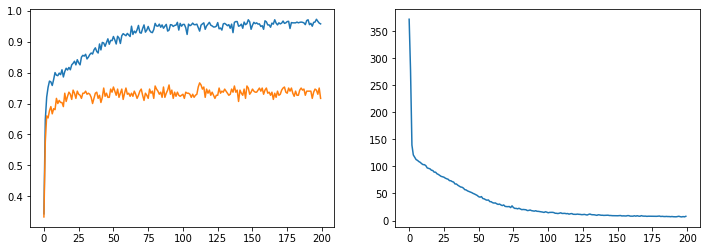

20.06877158984571 0.7166666666666667


In [149]:
# Actually train
model_row_kl = ConvNetPdBig(log_softmax=True, softmax=False, channels=3, dropout=0.5)
model_row_kl = model_row_kl.to(DEVICE)

criterion = nn.KLDivLoss(reduction='sum')
optimizer = optim.Adam(model_row_kl.parameters(), lr=1e-4, weight_decay=0.0001)

dataloader = load_game_data(train_val_data_row, train_val_labels, batch_size=4, shuffle=True)
EPOCHS = 50

dataloader_val = load_game_data(train_val_data_row, train_val_labels, batch_size=1, shuffle=False)
losses_4, acc_4 = train(model_row_kl, criterion, dataloader, dataloader_val, epochs=200, 
                        log_targets=False, model_softmax=True, log=20, val_data=test_data_row, val_labels=test_labels)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc_4[0])
plt.plot(acc_4[1])
plt.subplot(1, 2, 2)
plt.plot(losses_4)
plt.show()

dataloader_val = load_game_data(test_data_row, test_labels, batch_size=1, shuffle=False)
batch_ql, acc, predictions = evaluate(model_row_kl, dataloader_val)
print(batch_ql, acc)

In [0]:
torch.save(model_row_kl.state_dict(), './model_row_kl_200.pt')

Epoch 4  | Training Loss: 5.732925 | Quad Loss: 65.452151 | Acc: 0.776667 | Val Quad Loss: 21.466726 | Val Acc: 0.683333
Epoch 9  | Training Loss: 5.134506 | Quad Loss: 56.162071 | Acc: 0.787500 | Val Quad Loss: 20.315297 | Val Acc: 0.706667
Epoch 14 | Training Loss: 4.808044 | Quad Loss: 61.334255 | Acc: 0.791667 | Val Quad Loss: 21.846888 | Val Acc: 0.693333
Epoch 19 | Training Loss: 4.567852 | Quad Loss: 54.661009 | Acc: 0.804167 | Val Quad Loss: 21.299158 | Val Acc: 0.716667
Epoch 24 | Training Loss: 4.322043 | Quad Loss: 47.067312 | Acc: 0.820833 | Val Quad Loss: 19.435463 | Val Acc: 0.730000
Epoch 29 | Training Loss: 3.995997 | Quad Loss: 45.444504 | Acc: 0.826667 | Val Quad Loss: 19.066973 | Val Acc: 0.726667
Epoch 34 | Training Loss: 3.842869 | Quad Loss: 45.761366 | Acc: 0.832500 | Val Quad Loss: 19.057477 | Val Acc: 0.736667
Epoch 39 | Training Loss: 3.549408 | Quad Loss: 45.837427 | Acc: 0.817500 | Val Quad Loss: 20.069727 | Val Acc: 0.696667
Epoch 44 | Training Loss: 3.2592

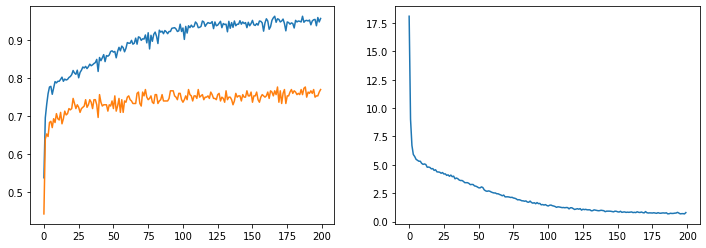

17.01859773306205 0.77


In [35]:
# Actually train
model_row_mse = ConvNetPdBig(log_softmax=False, softmax=True)
model_row_mse = model_row_mse.to(DEVICE)

criterion = nn.MSELoss()
optimizer = optim.Adam(model_row_mse.parameters(), lr=1e-4, weight_decay=0.0001)

dataloader = load_game_data(train_val_data_row, train_val_labels, batch_size=4, shuffle=True)
EPOCHS = 50

dataloader_val = load_game_data(train_val_data_row, train_val_labels, batch_size=1, shuffle=False)
losses_row_mse, acc_row_mse = train(model_row_mse, criterion, dataloader, dataloader_val, epochs=200, 
                        log_targets=False, model_softmax=True, log=5, val_data=test_data_row, val_labels=test_labels)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc_row_mse[0])
plt.plot(acc_row_mse[1])
plt.subplot(1, 2, 2)
plt.plot(losses_row_mse)
plt.show()

dataloader_val = load_game_data(test_data_row, test_labels, batch_size=1, shuffle=False)
batch_ql, acc, predictions = evaluate(model_row_mse, dataloader_val)
print(batch_ql, acc)

In [0]:
torch.save(model_row_mse.state_dict(), './model_row_mse_200.pt')

Epoch 49 | Training Loss: 1.017269 | Quad Loss: 48.058239 | Acc: 0.803333 | Val Quad Loss: 20.145192 | Val Acc: 0.716667
Epoch 99 | Training Loss: 0.763589 | Quad Loss: 36.323392 | Acc: 0.854167 | Val Quad Loss: 19.382254 | Val Acc: 0.730000
Epoch 149 | Training Loss: 0.539620 | Quad Loss: 22.969640 | Acc: 0.902500 | Val Quad Loss: 19.040838 | Val Acc: 0.753333
Epoch 199 | Training Loss: 0.366539 | Quad Loss: 17.904782 | Acc: 0.935000 | Val Quad Loss: 21.439693 | Val Acc: 0.746667


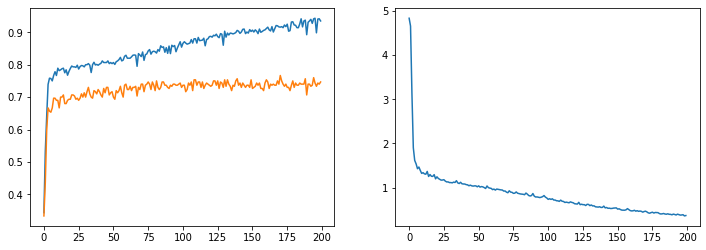

21.43969276241114 0.7466666666666667


In [37]:
# Actually train
model_row_mse_bs16 = ConvNetPdBig(log_softmax=False, softmax=True)
model_row_mse_bs16 = model_row_mse_bs16.to(DEVICE)

criterion = nn.MSELoss()
optimizer = optim.Adam(model_row_mse_bs16.parameters(), lr=1e-4, weight_decay=0.0001)

dataloader = load_game_data(train_val_data_row, train_val_labels, batch_size=16, shuffle=True)
EPOCHS = 50

dataloader_val = load_game_data(train_val_data_row, train_val_labels, batch_size=1, shuffle=False)
losses_row_mse_bs16, acc_row_mse_bs16 = train(model_row_mse_bs16, criterion, dataloader, dataloader_val, epochs=200, 
                        log_targets=False, model_softmax=True, log=50, val_data=test_data_row, val_labels=test_labels)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc_row_mse_bs16[0])
plt.plot(acc_row_mse_bs16[1])
plt.subplot(1, 2, 2)
plt.plot(losses_row_mse_bs16)
plt.show()

dataloader_val = load_game_data(test_data_row, test_labels, batch_size=1, shuffle=False)
batch_ql, acc, predictions = evaluate(model_row_mse_bs16, dataloader_val)
print(batch_ql, acc)

## **Training Setup 3: All Features**

Epoch 49 | Training Loss: 36.372822 | Quad Loss: 14.584004 | Acc: 0.918333 | Val Quad Loss: 19.819529 | Val Acc: 0.756667
Epoch 99 | Training Loss: 14.382340 | Quad Loss: 5.779181 | Acc: 0.940000 | Val Quad Loss: 21.214062 | Val Acc: 0.730000
Epoch 149 | Training Loss: 8.799513 | Quad Loss: 4.506994 | Acc: 0.947500 | Val Quad Loss: 20.077520 | Val Acc: 0.723333
Epoch 199 | Training Loss: 7.353274 | Quad Loss: 4.520711 | Acc: 0.953333 | Val Quad Loss: 19.178327 | Val Acc: 0.733333


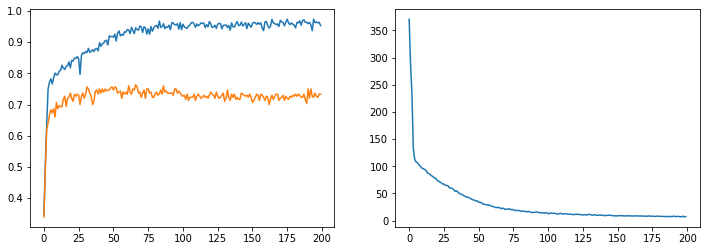

19.17832728326721 0.7333333333333333


In [148]:
# Actually train
model_all_kl = ConvNetPdBig(log_softmax=True, softmax=False, channels=5, dropout=0.5)
model_all_kl = model_all_kl.to(DEVICE)

criterion = nn.KLDivLoss(reduction='sum')
optimizer = optim.Adam(model_all_kl.parameters(), lr=1e-4, weight_decay=0.0001)

dataloader = load_game_data(train_val_data_combined, train_val_labels, batch_size=4, shuffle=True)
EPOCHS = 50

dataloader_val = load_game_data(train_val_data_combined, train_val_labels, batch_size=1, shuffle=False)
losses_all_kl, acc_all_kl = train(model_all_kl, criterion, dataloader, dataloader_val, epochs=200, 
                        log_targets=False, model_softmax=True, log=50, val_data=test_data_combined, val_labels=test_labels)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc_all_kl[0])
plt.plot(acc_all_kl[1])
plt.subplot(1, 2, 2)
plt.plot(losses_all_kl)
plt.show()

dataloader_val = load_game_data(test_data_combined, test_labels, batch_size=1, shuffle=False)
batch_ql, acc, predictions = evaluate(model_all_kl, dataloader_val)
print(batch_ql, acc)

torch.save(model_all_kl.state_dict(), './model_all_mse_200.pt')

In [0]:
torch.save(model_all_kl.state_dict(), './model_all_kl_200.pt')

Epoch 49 | Training Loss: 2.933395 | Quad Loss: 33.651457 | Acc: 0.856667 | Val Quad Loss: 17.459091 | Val Acc: 0.750000
Epoch 99 | Training Loss: 1.576652 | Quad Loss: 16.703812 | Acc: 0.924167 | Val Quad Loss: 17.082877 | Val Acc: 0.756667
Epoch 149 | Training Loss: 0.956387 | Quad Loss: 10.207319 | Acc: 0.939167 | Val Quad Loss: 16.862333 | Val Acc: 0.780000
Epoch 199 | Training Loss: 0.768985 | Quad Loss: 7.134205 | Acc: 0.956667 | Val Quad Loss: 16.629310 | Val Acc: 0.780000


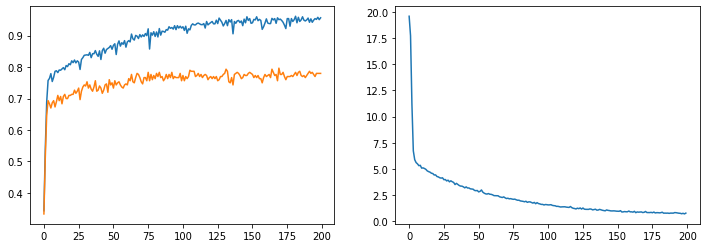

16.629310223379434 0.78


In [151]:
# Actually train
model_all_mse = ConvNetPdBig(log_softmax=False, softmax=True, dropout=0.5, channels=5)
model_all_mse = model_all_mse.to(DEVICE)

criterion = nn.MSELoss()
optimizer = optim.Adam(model_all_mse.parameters(), lr=1e-4, weight_decay=0.0001)

dataloader = load_game_data(train_val_data_combined, train_val_labels, batch_size=4, shuffle=True)
EPOCHS = 50

dataloader_val = load_game_data(train_val_data_combined, train_val_labels, batch_size=1, shuffle=False)
losses_all_mse, acc_all_mse = train(model_all_mse, criterion, dataloader, dataloader_val, epochs=200, 
                        log_targets=False, model_softmax=True, log=50, val_data=test_data_combined, val_labels=test_labels)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc_all_mse[0])
plt.plot(acc_all_mse[1])
plt.subplot(1, 2, 2)
plt.plot(losses_all_mse)
plt.show()

dataloader_val = load_game_data(test_data_combined, test_labels, batch_size=1, shuffle=False)
batch_ql, acc, predictions = evaluate(model_all_mse, dataloader_val)
print(batch_ql, acc)

torch.save(model_all_mse.state_dict(), './model_all_mse_200.pt')

## **Visualize Spatial Activations**

### **Define methods**

In [0]:
def get_cam_heatmaps(model, layer, dataloader, indices):
    model.eval()

    samples = []
    labels = []
    heatmaps = []
    predictions = []

    for batch_ix, (data, label) in enumerate(dataloader):
        samples.append(data)
        labels.append(np.round(label.detach().cpu().numpy().squeeze(), decimals=3))

    selected_samples = [samples[ix] for ix in range(len(samples)) if ix in indices]
    for sample in selected_samples:
        pred = model(sample)
        target = pred.argmax(dim=1)

        # Get gradient of output wrt model params
        pred[:, target].backward()
        # Pull gradients out of model
        gradients = model.get_activations_gradient()

        pooled_gradients = torch.mean(gradients, dim=[0, 2, 3]) # Pool grads across channels
        activations = model.get_activations(data)
        activations = activations[layer].detach()  # Get activations of last conv layer
        # Weight channel activations by gradients
        for i in range(activations.shape[1]):
            activations[:, i, :, :] *= pooled_gradients[i]

        # Calculate heatmap valules
        heatmap = torch.mean(activations, dim=1).squeeze()

        # ReLU on heatmap
        zeros = torch.zeros(heatmap.shape).cuda()
        heatmap = torch.max(heatmap, zeros)  # ReLU on heatmap
        heatmap /= torch.max(heatmap)  # Normalize
        heatmaps.append(heatmap)
        predictions.append(pred.detach().cpu().numpy().squeeze())
    return heatmaps, [labels[ix] for ix in range(len(labels)) if ix in indices], predictions


In [0]:
def visualize_heatmaps(heatmaps, labels, predictions, data, show_payoffs=False, diff_data=None, show_diffs=False):
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 10))
    fig.subplots_adjust(hspace=0.4, wspace=0)

    selected_data = data

    for ix, ax in enumerate(axes.flat):
        viz = ax.matshow(heatmaps[ix].squeeze().detach().cpu().numpy())
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        # ax.text('test', ha='center', va='center')
        if show_payoffs:
            for i in range(selected_data.shape[2]):
                for j in range(selected_data.shape[2]):
                    color = 'w' if heatmaps[ix][i, j] < 0.4 else 'b'  # visibility
                    text = ax.text(j, i, '({}, {})'.format(int(selected_data[ix][0][i, j] * 100),
                                                          int(selected_data[ix][1][i, j] * 100)), 
                                  ha="center", va="center", color=color) 
                    
        elif show_diffs:
            for i in range(diff_data.shape[2]):
                for j in range(diff_data.shape[2]):
                    color = 'w' if heatmaps[ix][i, j] < 0.4 else 'b'  # visibility
                    text = ax.text(j, i, '({:.2f}, {:.2f})'.format(diff_data[ix][0][i, j],
                                                           diff_data[ix][1][i, j]), 
                                   ha="center", va="center", color=color, fontsize=7) 

        pred_str = [np.round(pred, 3) for pred in predictions[ix]]
        ax.title.set_text('{}\n{}'.format(labels[ix], pred_str))

    fig.colorbar(viz, ax=axes.ravel().tolist())
    plt.show()

### **Row MSE Model**

In [42]:
## Load saved model (with hooks this time)
model_row_mse_s = ConvNetPdBig(softmax=True, dropout=0.5, channels=3)
model_row_mse_s.load_state_dict(torch.load('./model_row_mse_200.pt'))
model_row_mse_s.to(DEVICE)
model_row_mse_s.eval()

ConvNetPdBig(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1152, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=3, bias=True)
  (log_softmax): LogSoftmax()
  (softmax): Softmax(dim=1)
  (dropout_conv): Dropout2d(p=0.1, inplace=False)
  (dropout_fcn): Dropout(p=0.5, inplace=False)
)

In [0]:
dataloader_val = load_game_data(test_data_row, test_labels, batch_size=1, shuffle=False)

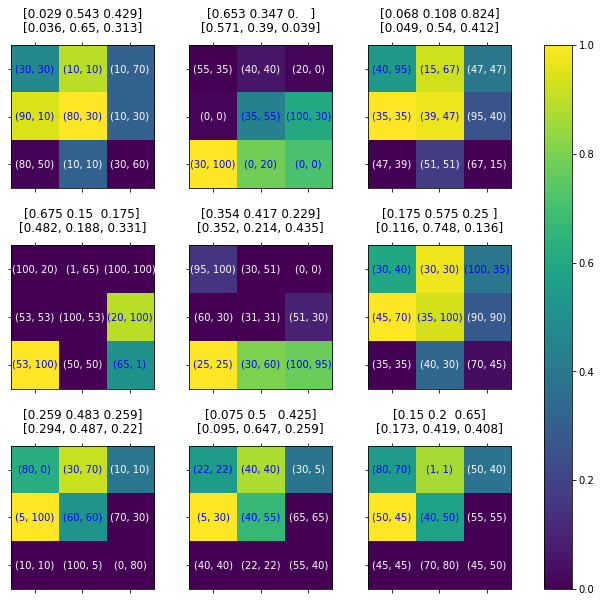

In [136]:
indices = list(range(0, 9))
heatmaps, labels, predictions = get_cam_heatmaps(model_row_mse_s, -1, dataloader_val, indices=indices)
visualize_heatmaps(heatmaps, labels, predictions, data=test_data[indices], show_payoffs=True)

In [92]:
test_data_diffs[indices][0][0]

array([[ 0. ,  0. , -0.6],
       [ 0.8,  0.5, -0.2],
       [ 0.3,  0. , -0.3]])

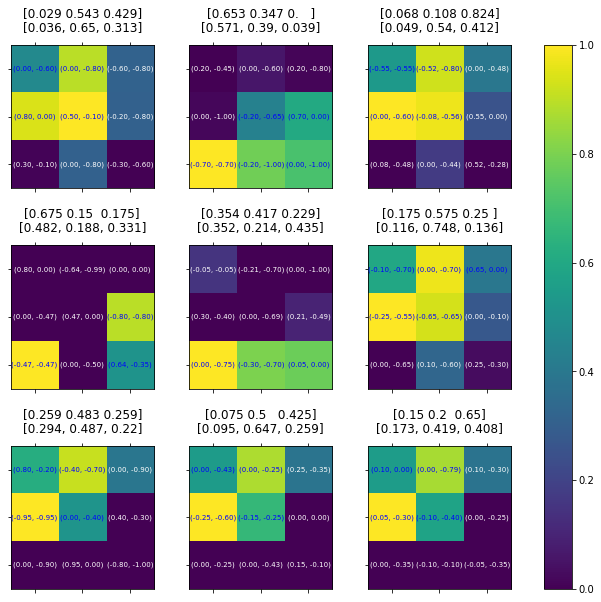

In [139]:
indices = list(range(0, 9))
heatmaps, labels, predictions = get_cam_heatmaps(model_row_mse_s, -1, dataloader_val, indices=indices)
visualize_heatmaps(heatmaps, labels, predictions, data=test_data[indices], show_payoffs=False, diff_data=test_data_diffs[indices], show_diffs=True)

#### **Sanity Check with Training Data**

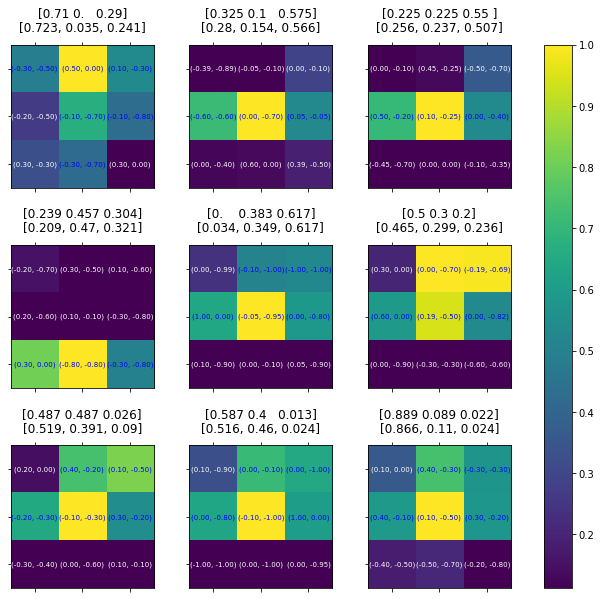

In [143]:
dataloader_train = load_game_data(train_val_data_row, train_val_labels, batch_size=1, shuffle=False)
indices = list(range(0, 9))
heatmaps, labels, predictions = get_cam_heatmaps(model_row_mse_s, -1, dataloader_train, indices=indices)
visualize_heatmaps(heatmaps, labels, predictions, data=train_val_data[indices], show_payoffs=False, diff_data=train_val_data_diffs[indices], show_diffs=True)

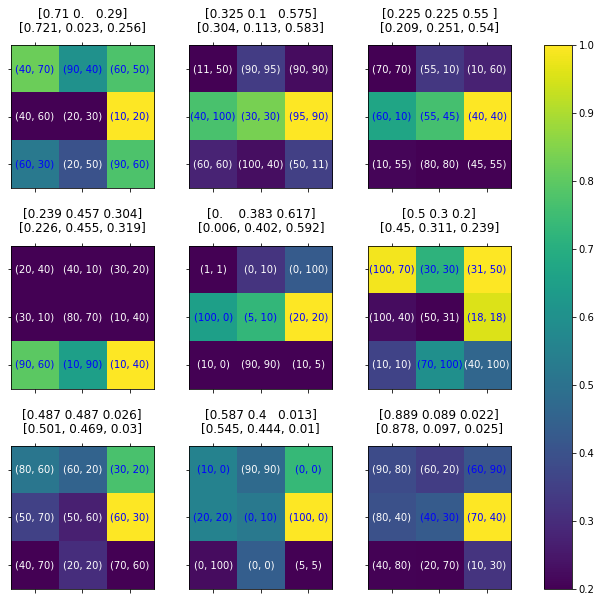

In [145]:
dataloader_train = load_game_data(train_val_data_row, train_val_labels, batch_size=1, shuffle=False)
indices = list(range(0, 9))
heatmaps, labels, predictions = get_cam_heatmaps(model_row_kl_s, -1, dataloader_train, indices=indices)
visualize_heatmaps(heatmaps, labels, predictions, data=train_val_data[indices], show_payoffs=True, 
                   diff_data=train_val_data_diffs[indices], show_diffs=False)

In [0]:
dataloader_train = load_game_data(train_val_data_row, train_val_labels, batch_size=1, shuffle=False)
indices = list(range(0, 9))
heatmaps, labels, predictions = get_cam_heatmaps(model_row_mse_s, -1, dataloader_train, indices=indices)
visualize_heatmaps(heatmaps, labels, predictions, data=train_val_data[indices], show_payoffs=True)

### **Row KL Model**

In [53]:
## Load saved model (with hooks this time)
model_row_kl_s = ConvNetPdBig(softmax=True, dropout=0.5, channels=3)
model_row_kl_s.load_state_dict(torch.load('./model_row_kl_200.pt'))
model_row_kl_s.to(DEVICE)
model_row_kl_s.eval()

ConvNetPdBig(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1152, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=3, bias=True)
  (log_softmax): LogSoftmax()
  (softmax): Softmax(dim=1)
  (dropout_conv): Dropout2d(p=0.1, inplace=False)
  (dropout_fcn): Dropout(p=0.5, inplace=False)
)

In [0]:
dataloader_val = load_game_data(test_data_row, test_labels, batch_size=1, shuffle=False)

/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


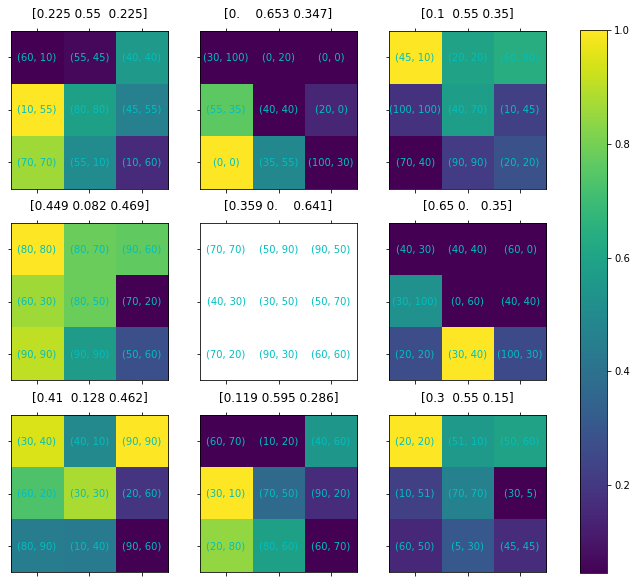

In [60]:
indices = list(range(100, 109))
heatmaps, labels, predictions = get_cam_heatmaps(model_row_kl_s, 0, dataloader_val, indices=indices)
visualize_heatmaps(heatmaps, labels, data=test_data[indices], show_payoffs=True)

### **Combined KL Model**

In [152]:
## Load saved model (with hooks this time)
model_all_kl_s = ConvNetPdBig(softmax=True, dropout=0.5, channels=5)
model_all_kl_s.load_state_dict(torch.load('./model_all_kl_200.pt'))
model_all_kl_s.to(DEVICE)
model_all_kl_s.eval()

ConvNetPdBig(
  (conv1): Conv2d(5, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1152, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=3, bias=True)
  (log_softmax): LogSoftmax()
  (softmax): Softmax(dim=1)
  (dropout_conv): Dropout2d(p=0.1, inplace=False)
  (dropout_fcn): Dropout(p=0.5, inplace=False)
)

In [0]:
dataloader_val = load_game_data(test_data_combined, test_labels, batch_size=1, shuffle=False)

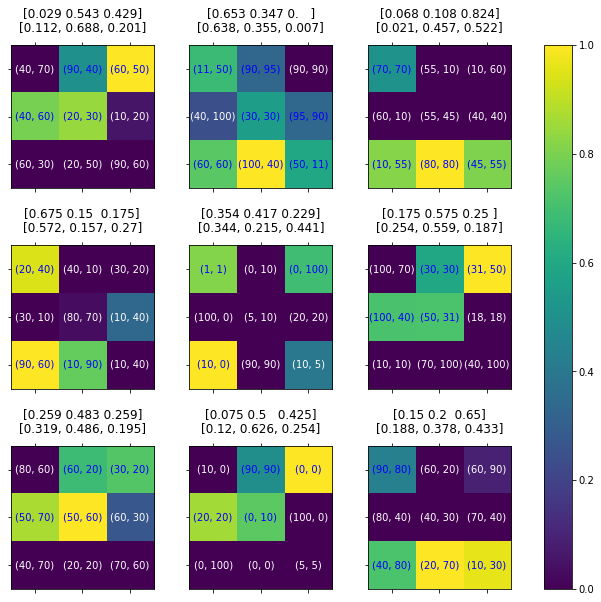

In [154]:
indices = list(range(0, 9))
heatmaps, labels, predictions = get_cam_heatmaps(model_all_kl_s, -1, dataloader_val, indices=indices)
visualize_heatmaps(heatmaps, labels, predictions, data=train_val_data[indices], show_payoffs=True, 
                   diff_data=train_val_data_diffs[indices], show_diffs=False)

### **Combined MSE Model**

In [155]:
## Load saved model (with hooks this time)
model_all_mse_s = ConvNetPdBig(softmax=True, dropout=0.5, channels=5)
model_all_mse_s.load_state_dict(torch.load('./model_all_mse_200.pt'))
model_all_mse_s.to(DEVICE)
model_all_mse_s.eval()

ConvNetPdBig(
  (conv1): Conv2d(5, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1152, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=3, bias=True)
  (log_softmax): LogSoftmax()
  (softmax): Softmax(dim=1)
  (dropout_conv): Dropout2d(p=0.1, inplace=False)
  (dropout_fcn): Dropout(p=0.5, inplace=False)
)

In [0]:
dataloader_val = load_game_data(test_data_combined, test_labels, batch_size=1, shuffle=False)

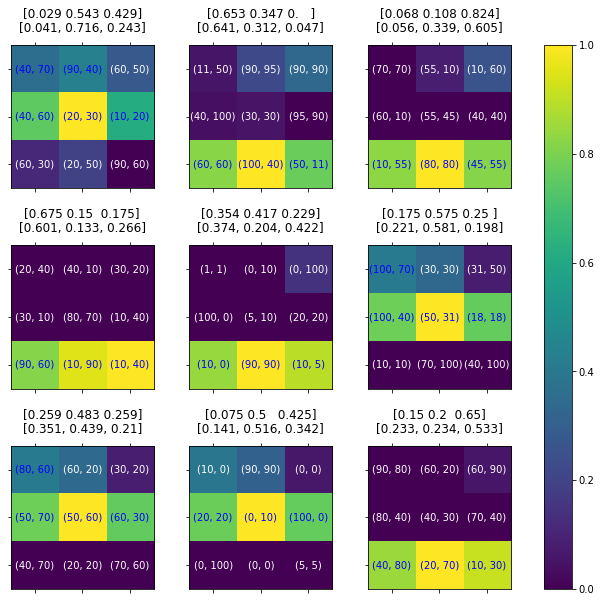

In [157]:
indices = list(range(0, 9))
heatmaps, labels, predictions = get_cam_heatmaps(model_all_mse_s, -1, dataloader_val, indices=indices)
visualize_heatmaps(heatmaps, labels, predictions, data=train_val_data[indices], show_payoffs=True, 
                   diff_data=train_val_data_diffs[indices], show_diffs=False)

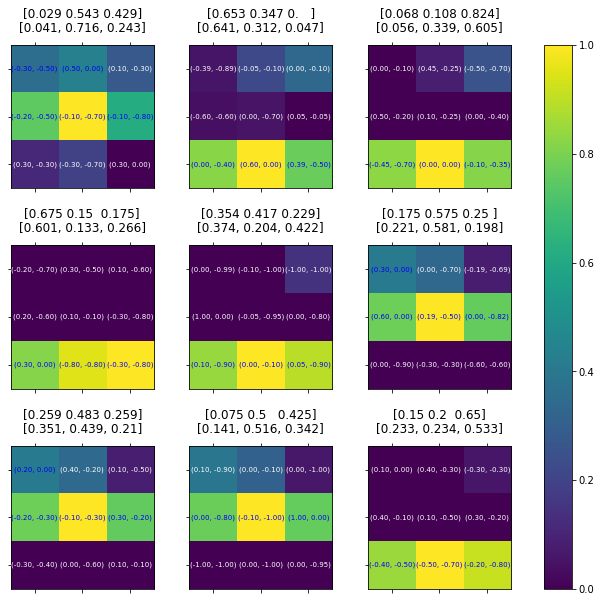

In [158]:
indices = list(range(0, 9))
heatmaps, labels, predictions = get_cam_heatmaps(model_all_mse_s, -1, dataloader_val, indices=indices)
visualize_heatmaps(heatmaps, labels, predictions, 
                   data=train_val_data[indices], show_payoffs=False, 
                   diff_data=train_val_data_diffs[indices], show_diffs=True)